In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

file = 'drive/MyDrive/data/Retrosheet_2010_2019/2010_to_2019_seasons.csv'
game_df = pd.read_csv(file)

game_col_del = '''VisitorGDP,VisitorCI,HomeGDP,HomeCI, DoubleHeader, DayOfWeek, VisitingTeamLeague, HomeTeamLeague, DayNight, CompletionInfo,ForfeitInfo, ProtestInfo,Duration, VisitorLineScore, HomeLineScore, UmpireHID, UmpireHName, Umpire1BID, Umpire1BName, Umpire2BID,Umpire2BName, Umpire3BID, Umpire3BName, UmpireLFID, UmpireLFName, UmpireRFID,UmpireRFName, VisitorManagerID, VisitorManagerName, HomeManagerID, HomeManagerName,WinningPitcherID, WinningPitcherName, LosingPitcherID, LosingPitcherNAme,SavingPitcherID, SavingPitcherName, GameWinningRBIID, GameWinningRBIName, VisitorBatting1Position, VisitorBatting2Position, VisitorBatting3Position,VisitorBatting4Position, VisitorBatting5Position, VisitorBatting6Position,VisitorBatting7Position, VisitorBatting8Position, VisitorBatting9Position,HomeBatting1Position, HomeBatting2Position, HomeBatting3Position,HomeBatting4Position, HomeBatting5Position, HomeBatting6Position,HomeBatting7Position, HomeBatting8Position, HomeBatting9Position,AdditionalInfo, AcquisitionInfo'''
game_col_del = game_col_del.replace(" ", "")
game_col_del = game_col_del.split(",")

game_df.drop(game_col_del,axis=1,inplace=True)

my_attendence={'BOS':37755, 'LAA':45517, 'CWS':40615, 'KC':37903, 'OAK':56782, 'TEX':40300, 'ARI':48686, 'ATL':41084, 'CIN':42319,
       'HOU':41168, 'MIL':41900, 'NYM':41922, 'PIT':38747, 'WAS':41339, 'TB':42735, 'BAL':44970, 'DET':41083, 'COL':50144,
       'MIA':37442, 'SF':41265, 'CLE':34830, 'MIN':38544, 'SEA':47929, 'TOR':49282, 'CHC':41649, 'PHI':42792, 'SD':40209, 'STL':45494,
       'NYY':54251, 'LAD':56000}
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)

for key, value in my_attendence.items():
  game_df.loc[game_df['HomeTeam']==key,'Attendence']=game_df.loc[game_df['HomeTeam']==key,'Attendence']/value


file4 = 'drive/MyDrive/data/park_factors.csv'
parkfactor_df = pd.read_csv(file4, encoding='cp949')
parkfactor_df

# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
parkfactor_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
parkfactor_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)


game_df = pd.merge(game_df, parkfactor_df, on="HomeTeam")

col_del = ['VisitorBatting1PlayerID', 'VisitorBatting1Name', 'VisitorBatting2PlayerID', 'VisitorBatting2Name', 'VisitorBatting3PlayerID', 'VisitorBatting3Name', 'VisitorBatting4PlayerID', 'VisitorBatting4Name', 'VisitorBatting5PlayerID', 'VisitorBatting5Name', 'VisitorBatting6PlayerID', 'VisitorBatting6Name', 'VisitorBatting7PlayerID', 'VisitorBatting7Name', 'VisitorBatting8PlayerID', 'VisitorBatting8Name', 'VisitorBatting9PlayerID', 'VisitorBatting9Name', 'HomeBatting1PlayerID', 'HomeBatting1Name', 'HomeBatting2PlayerID', 'HomeBatting2Name', 'HomeBatting3PlayerID', 'HomeBatting3Name', 'HomeBatting4PlayerID', 'HomeBatting4Name', 'HomeBatting5PlayerID', 'HomeBatting5Name', 'HomeBatting6PlayerID', 'HomeBatting6Name', 'HomeBatting7PlayerID', 'HomeBatting7Name', 'HomeBatting8PlayerID', 'HomeBatting8Name', 'HomeBatting9PlayerID', 'HomeBatting9Name']
game_df.drop(col_del,axis=1,inplace=True)
game_df = game_df.rename(columns={"VisitingTeam":"VisitorTeam","VisitingTeamGameNumber":"VisitorTeamGameNumber"})

game_df['Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')
game_df['current_year'] = game_df['Date'].dt.year

game_df['prior_year']=game_df['current_year']-1
print(game_df.Attendence)
trend=1 #몇일 롤링
game_df[f'{trend}d_home_attendance'] = game_df.groupby(['current_year', 'HomeTeam'])['Attendence'].transform(lambda x: round(x.rolling(trend).mean().shift(periods=1, axis=0), 3))
print(game_df[f'{trend}d_home_attendance'])

away_inning = game_df['LengthInOuts']//2
home_inning = game_df['LengthInOuts']- away_inning


game_df['VisitorOffInn'] = away_inning
game_df['VisitorDifInn'] = home_inning
game_df['HomeOffInn'] = home_inning
game_df['HomeDifInn'] = away_inning

game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']
game_df['Visitor_team_won?'] = game_df['HomeRunsScore'] < game_df['VisitorRunsScored']

bat_stat = [ 'TeamGameNumber','Team','AB','H','D','T','HR','RBI','SH','SF',
'HBP','BB','IBB','K','SB','CS','LOB','Pitchers',
'ER','TER','WP','Balks','PO','A','E','Passed','DB','TP','OffInn','DifInn','_team_won?']
pit_stat = ['H', 'D', 'T', 'HR', 'RBI', 'SH', 'SF', 'HBP', 'BB', 'IBB', 'K', 'LOB', 'ER','DB','AB']

select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}

## Home 시각 
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}
Home = game_df.copy()
Home = Home[select_stat].rename(columns=rename1)
Home = Home.rename(columns=rename2)
# away 시각
select_stat = ['Date']
select_stat += ['Visitor'+i for i in bat_stat]+['Home'+i for i in pit_stat]
rename1 = {'Home'+i:'Pit'+i for i in pit_stat}
rename2 = {'Visitor'+i:i for i in bat_stat}
Visitor = game_df.copy()
Visitor = Visitor[select_stat].rename(columns=rename1)
Visitor = Visitor.rename(columns=rename2)

sep_team = pd.concat([Home,Visitor])
sep_team = sep_team.rename(columns={'PitDB':'DP'})
sep_team

col = ['AB', 'H', 'D', 'T', 'HR', 'RBI','DP',
       'SF', 'BB', 'K', 'SB', 'CS', 'LOB', 'Pitchers', 'ER', 'TER', 'WP','PitAB',
       'Balks', 'PO', 'A', 'E', 'Passed', 'DB', 'TP', 'OffInn', 'DifInn',
       'PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF',
       'PitBB', 'PitK', 'PitLOB', 'PitER']


a = sep_team.copy()
sep_team['year']= sep_team.Date.dt.year
sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.expanding(1).sum())
sep_team[col] = sep_team[col].subtract(a[col])
sep_team = sep_team[sep_team['TeamGameNumber']>=10] #최소 10경기 이상
sep_team

select_feature = ['Date', 'TeamGameNumber', 'Team','_team_won?']
# feature selection
select_feature += ['AB', 'H', 'D', 'T', 'HR', 'RBI','BB', 'K','DP', 'HBP','IBB','SF','SH',#bat stat
                    'ER','OffInn','DifInn' # game info
                    ,'PitAB','PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF', 'PitBB',"PitIBB","PitHBP" ,'PitK','PitLOB', 'PitER'
                    ]
sep = sep_team[select_feature] 
# H, OBP, SLG, ISO, Babip, RC, wOBA X, K, BB, RBI, K/B, HR   
# 타자 가공
sep['RC'] = ((sep['H']+sep['BB']+sep['HBP']-sep['DP'])
        *(sep['H']+2*sep['D']+3*sep['T']+4*sep['HR']+0.52*(sep['SF']+sep['SH'])+0.26*(sep['BB']+sep['HBP']-sep['IBB']))
        )/(sep['AB']*sep['AB']) #득점 생산


#사구,사사구, 고의사구 통합
sep['BB'] += sep['HBP']+sep['IBB']
sep['PitBB'] += sep['PitHBP']+sep['PitIBB']
#del sep['HBP'],sep['IBB'],sep['PitHBP'],sep['PitIBB']
# 희생번트, 희생플라이 통합
sep['PitSF'] += sep_team['PitSH']
sep['SF'] += sep['SH']
#del sep['SH'],sep['PitSH']

sep['K/B'] = sep['K']/(sep['BB']+0.5)
sep['PA'] = sep['AB'] - sep['BB'] - sep['SF'] # 타수
sep['Babip'] = (sep['H']+sep['D']+sep['T']) / (sep['PA']-sep['K']-sep['HR']-sep['SF']) # 인플레이 타구
sep['SLG'] = (sep['H']+2*sep['D']+3*sep['T']+4*sep['HR'])/sep['PA'] # 장타율
sep['H'] = sep['H']/sep['PA'] # 안타율
sep['D'] = sep['D']/sep['PA'] # 안타율
sep['T'] = sep['T']/sep['PA'] # 안타율
sep['HR'] = sep['HR']/sep['PA'] # 안타율
sep['BB'] = sep['BB']/sep['PA'] # 볼넷
sep['RBI'] = sep['RBI']/sep['TeamGameNumber'] # 득점

sep['OBP'] = (sep['H']+sep['BB']) #출루율
sep['OPS'] = sep['SLG']+sep['OBP'] #OPS
sep['GPA'] = (1.8*sep['OBP']+sep['SLG'])/4#GPA(Gross Production Average) - park factor를 적용해야함
sep['ISO'] = sep['SLG'] - sep['H']
# 투수 가공
# PitH, PitOBP, PitSLG, PitOPS, PitHR, EAR, PitB, PitK, PitK/B, WHIP, kwERA
sep['ERA'] = sep['PitER']/sep['DifInn']
sep['TotalH'] = sep['PitH']+sep['PitD']+sep['PitT']+sep['PitHR']
sep['TotalBB'] = sep['PitBB']+sep['PitHBP']
sep['PitPA'] = sep['PitAB'] - sep['TotalBB'] - sep['PitSF']
sep['kwERA'] = (5.40-12*(sep['PitK'] - sep['TotalBB']))/sep['PitPA']
sep['WHIP'] = (sep['TotalH']+sep['TotalBB'])/sep['DifInn']
sep['PitK'] = sep['PitK']/sep['DifInn']
sep['PitB'] = sep['TotalBB']/sep['DifInn']
sep['PitK/B'] = sep['PitK']/(sep['PitB']+0.5)


sep['PitSLG'] = (sep['PitH']+2*sep['PitD']+3*sep['PitT']+4*sep['PitHR'])/sep['PitPA'] # 피장타율
sep['PitH'] = sep['PitH']/sep['PitPA'] # 피안타율
sep['PitOBP'] = (sep['TotalH']+sep['TotalBB']) / sep['PitAB'] #피출루율
sep['PitOPS'] = sep['PitSLG']+sep['PitOBP'] #피OPS
sep['PitHR'] /= sep['PitPA']

#ParkFactors

temp = sep
game_log = game_df[['Date','VisitorTeam','HomeTeam','VisitorTeamGameNumber','HomeTeamGameNumber',f'{trend}d_home_attendance','ParkFactors']]

game_log = game_log[game_log.VisitorTeamGameNumber>=10]
game_log = game_log[game_log.HomeTeamGameNumber>=10]



game_log = pd.merge(game_log,temp,left_on = ['Date','VisitorTeam'], right_on = ['Date','Team'],how='left')
game_log = pd.merge(game_log,temp,left_on = ['Date','HomeTeam'], right_on = ['Date','Team'],how='left')

game_log['year'] = game_log.Date.dt.year

train = game_log[game_log.year!=2019]
test = game_log[game_log.year==2019]

y_cols = ['_team_won?_x']
select = ['H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','ERA','PitB','PitK','PitK/B','WHIP']
#select = ['H', 'D', 'T', 'HR', 'RBI', 'BB']
x_cols = [i+'_x' for i in select]
x_cols += [i+'_y' for i in select]
train = train.dropna()
test = test.dropna()

x_cols += [f'{trend}d_home_attendance']
x_cols += ['ParkFactors']

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive
0        0.991657
1        1.006489
2        1.012793
3        0.982228
4        0.980585
           ...   
24292    0.868982
24293    0.861661
24294    0.959000
24295    0.905446
24296    0.856214
Name: Attendence, Length: 24297, dtype: float64
0          NaN
1        0.992
2        1.006
3        1.013
4        0.982
         ...  
24292    0.934
24293    0.869
24294    0.862
24295    0.959
24296    0.905
Name: 1d_home_attendance, Length: 24297, dtype: float64


In [2]:
'''
    Z-score normalization
'''
scaler = StandardScaler()
scaler.fit(train[x_cols])
X_train = scaler.transform(train[x_cols])
X_test = scaler.transform(test[x_cols])

In [3]:
X_train = train[x_cols]
y_train = train[y_cols]*1

X_test = test[x_cols]
y_test = test[y_cols]*1

model = sm.Logit(y_train,X_train)
results = model.fit()
print(results.summary())

y_hat = results.predict( X_train)
y_hat = list(map(round,y_hat))
print('Train accuracy = ', accuracy_score(y_train, y_hat))

y_hat = results.predict( X_test)
y_hat = list(map(round,y_hat))
print('Test accuracy = ', accuracy_score(y_test, y_hat))

Optimization terminated successfully.
         Current function value: 0.679651
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           _team_won?_x   No. Observations:                21978
Model:                          Logit   Df Residuals:                    21940
Method:                           MLE   Df Model:                           37
Date:                Thu, 05 May 2022   Pseudo R-squ.:                 0.01561
Time:                        18:56:26   Log-Likelihood:                -14937.
converged:                       True   LL-Null:                       -15174.
Covariance Type:            nonrobust   LLR p-value:                 3.495e-77
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
H_x                    5.4616   2.96e+06   1.84e-06      1.000   -5.81e+06    5.81e+06
OBP_

In [4]:
num_thread = 8
# num of cpu 
param ={'num_leaves':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
lgb =LGBMClassifier()
lgb_clf = GridSearchCV(lgb,param,scoring='accuracy',n_jobs=num_thread)
lgb_results = lgb_clf.fit(X_train, y_train.values.ravel(), eval_metric=['logloss'],eval_set=[(X_test, y_test.values.ravel())],callbacks=[lightgbm.early_stopping(10, verbose=0)])

train_score = lgb_results.score(X_train, y_train)
test_score = lgb_results.score(X_test, y_test)
print(lgb_results.best_params_)
print(test_score)

rf_param ={'min_samples_split':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
rf =RandomForestClassifier()
rf_clf = GridSearchCV(rf,rf_param,scoring='accuracy',n_jobs=num_thread)
rf_results = rf_clf.fit(X_train,  y_train.values.ravel())


train_score = rf_results.score(X_train, y_train)
test_score = rf_results.score(X_test, y_test)
print(rf_results.best_params_)
print(test_score)

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
svm_param  = [{'C': param_range, 'kernel': ['linear']}, {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]
svm_model =svm.SVC()
svm_clf = GridSearchCV(estimator=svm_model,param_grid=svm_param,scoring='accuracy',n_jobs=num_thread,verbose=0)
svm_results = svm_clf.fit(X_train, y_train.values.ravel())

train_score = svm_results.score(X_train, y_train)
test_score = svm_results.score(X_test, y_test)
print(svm_results.best_params_)
print(test_score)

[1]	valid_0's binary_logloss: 0.689655
[2]	valid_0's binary_logloss: 0.688711
[3]	valid_0's binary_logloss: 0.68761
[4]	valid_0's binary_logloss: 0.686368
[5]	valid_0's binary_logloss: 0.685587
[6]	valid_0's binary_logloss: 0.684723
[7]	valid_0's binary_logloss: 0.684231
[8]	valid_0's binary_logloss: 0.684032
[9]	valid_0's binary_logloss: 0.682867
[10]	valid_0's binary_logloss: 0.681975
[11]	valid_0's binary_logloss: 0.681336
[12]	valid_0's binary_logloss: 0.680472
[13]	valid_0's binary_logloss: 0.679823
[14]	valid_0's binary_logloss: 0.679087
[15]	valid_0's binary_logloss: 0.678627
[16]	valid_0's binary_logloss: 0.678342
[17]	valid_0's binary_logloss: 0.677898
[18]	valid_0's binary_logloss: 0.677316
[19]	valid_0's binary_logloss: 0.676848
[20]	valid_0's binary_logloss: 0.67665
[21]	valid_0's binary_logloss: 0.676365
[22]	valid_0's binary_logloss: 0.675905
[23]	valid_0's binary_logloss: 0.675556
[24]	valid_0's binary_logloss: 0.674956
[25]	valid_0's binary_logloss: 0.674799
[26]	valid_

KeyboardInterrupt: ignored

In [6]:
# Requirements:
!pip install rtdl
!pip install libzero==0.0.4

from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

#device = torch.device('cpu')

device = torch.device("cuda:0")
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

In [ ]:
# !!! NOTE !!! The dataset splits, preprocessing and other details are
# significantly different from those used in the
# paper "Revisiting Deep Learning Models for Tabular Data",
# so the results will be different from the reported in the paper.

dataset = sklearn.datasets.fetch_california_housing()
task_type = 'regression'

# dataset = sklearn.datasets.fetch_covtype()
# task_type = 'multiclass'

assert task_type in ['binclass', 'multiclass', 'regression']

X_all = dataset['data'].astype('float32')
y_all = dataset['target'].astype('float32' if task_type == 'regression' else 'int64')
if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}
X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

In [29]:
X_train.shape

X = {}
y = {}

# X_train = train[x_cols]
# y_train = train[y_cols]*1

# X_test = test[x_cols]
# y_test = test[y_cols]*1
print(y_train)
y_train = sklearn.preprocessing.LabelEncoder().fit_transform(y_train).astype('int64')
y_test = sklearn.preprocessing.LabelEncoder().fit_transform(y_test).astype('int64')

print(y_train)

X['train']=X_train
X['test']=X_test
y['train']=y_train
y['test']=y_test


# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

print(X_train)
X['train']=torch.tensor(X['train'],dtype=torch.float32)
X['test']=torch.tensor(X['test'],dtype=torch.float32)
X['train']

X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
            H_x     OBP_x     SLG_x     ISO_x   Babip_x      RC_x     K_x  \
0      0.280959  0.427430  0.554816  0.273857  0.504551  0.179534   613.0   
1      0.278481  0.423832  0.550415  0.271934  0.500000  0.176896   624.0   
2      0.277155  0.422414  0.550000  0.272845  0.500000  0.176261   635.0   
3      0.277067  0.423274  0.552003  0.274936  0.500000  0.176786   641.0   
4      0.322424  0.429899  0.598384  0.275960  0.498421  0.202908   453.0   
...         ...       ...       ...       ...       ...       ...     ...   
24385  0.285483  0.387325  0.592833  0.307350  0.521844  0.181896  1375.0   
24386  0.259783  0.355460  0.509732  0.249949  0.483417  0.144400  1490.0   
24387  0.259825  0.355936  0.510283  0.250458  0.483510  0.144853  1499.0   
24388  0.259551  0.354760  0.509400  0.249848  0.482556  0.144393  1510.0   
24389  0.284507  0.385915  0.589940  0.305433  0.520852  0.180511  1391.0   

           BB_x      RBI_x     K/B_x  .

In [39]:
task_type ='binclass'
d_out = 1

model = rtdl.MLP.make_baseline(
    d_in=X_train.shape[1],
    d_layers=[128, 256, 128],
    dropout=0.1,
    d_out=d_out,
)
lr = 0.001
weight_decay = 0.0

# model = rtdl.ResNet.make_baseline(
#     d_in=X_all.shape[1],
#     d_main=128,
#     d_intermidiate=256,
#     dropout_first=0.2,
#     dropout_second=0.0,
#     n_blocks=2,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

# model = rtdl.FTTransformer.make_default(
#     n_num_features=X_all.shape[1],
#     cat_cardinalities=None,
#     last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
#     d_out=d_out,
# )

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [40]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.5091


In [41]:
n_epochs = 2000
report_frequency = len(X['train']) // batch_size // 5
myloss=[]
mytestaccuracy=[]
myvalaccuracy=[]
len_trainloader=len(train_loader)
for epoch in range(1, n_epochs + 1):
    avg_loss=0
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss=avg_loss / len_trainloader
    myloss.append(avg_loss)
    val_score = evaluate('val')
    myvalaccuracy.append(val_score)
    test_score = evaluate('test')
    mytestaccuracy.append(test_score)
    print(f'Epoch {epoch:03d} | loss: {avg_loss:.4f} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}')
    # progress.update((-1 if task_type == 'regression' else 1) * val_score)
    # if progress.success:
    #     print(' <<< BEST VALIDATION EPOCH', end='')
    # print()
    # if progress.fail:
    #     break

Epoch 001 | loss: 0.6845 | Validation score: 0.5594 | Test score: 0.5884
Epoch 002 | loss: 0.6813 | Validation score: 0.5557 | Test score: 0.5888
Epoch 003 | loss: 0.6800 | Validation score: 0.5571 | Test score: 0.5820
Epoch 004 | loss: 0.6786 | Validation score: 0.5544 | Test score: 0.5816
Epoch 005 | loss: 0.6769 | Validation score: 0.5523 | Test score: 0.5848
Epoch 006 | loss: 0.6755 | Validation score: 0.5587 | Test score: 0.5791
Epoch 007 | loss: 0.6732 | Validation score: 0.5548 | Test score: 0.5779
Epoch 008 | loss: 0.6707 | Validation score: 0.5548 | Test score: 0.5904
Epoch 009 | loss: 0.6688 | Validation score: 0.5694 | Test score: 0.5840
Epoch 010 | loss: 0.6660 | Validation score: 0.5646 | Test score: 0.5816
Epoch 011 | loss: 0.6628 | Validation score: 0.5591 | Test score: 0.5771
Epoch 012 | loss: 0.6588 | Validation score: 0.5612 | Test score: 0.5727
Epoch 013 | loss: 0.6556 | Validation score: 0.5662 | Test score: 0.5715
Epoch 014 | loss: 0.6518 | Validation score: 0.5619

In [42]:
import torch
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt




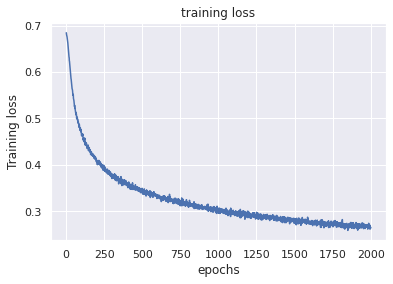

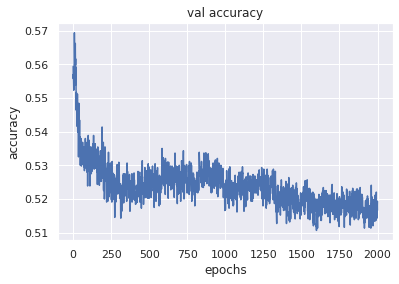

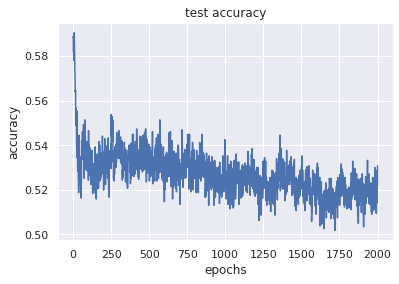

In [44]:
epoch_graph=np.arange(1,2001)

plt.plot(epoch_graph,myloss)
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.show()

plt.plot(epoch_graph,myvalaccuracy)
plt.title('val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(epoch_graph,mytestaccuracy)
plt.title('test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()